# Group Project Proposal 
### Group 007-37 - (Ja Kaewwetchawong, Inan Latif , Jossil Antigua , Kaye Thinh-To)

#### __Introduction:__

A movie’s gross earnings is an important indicator of success for studios, as it provides them information regarding the profit earned and a quantitative measure of the public’s interest. An individual's interest in watching a movie is influenced by a number of factors, one of them is the movie reviews. Often these reviews are provided by regular audiences as well as professional critics and are uploaded on sites such as Rotten Tomatoes or Imdb. Our group is interested in whether movie reviews can be used to accurately predict a movie’s gross earnings. Hence, we came up with the predictive question: What will be the range of a movie’s gross earnings if their metascore is 81 or more?

A metascore of 81 or higher is designated by critics as a “must see”. Therefore we decided to use this score as a baseline, once compared with gross earnings, this will let us know if a movie is really successful. To answer our question we will be using regression based on a dataset of 1000 movie observations containing Imdb and metacritic scores from Kaggle. 

__Predictive question 1:__ What will be a new movie’s gross earnings based on a dataset of movies from 2014?

__Predictive question 2:__ What will be the range of a movie’s gross earnings if their metascore is 81 or more?


In [28]:
### Run this cell before continuing. 
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
source("tests.R")
source('cleanup.R')
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


#### __Methods:__
First we read the data, and then cleaned the data and filtered out any irrelevant information. 


In [29]:
data <- read_csv("imdb_top_1000.csv")
ratings <- data %>%
    filter(Released_Year >= 2000, !is.na(Gross)) %>%
    filter(!is.na(Meta_score)) %>%
    select(Series_Title,Released_Year, Meta_score, Gross,IMDB_Rating, No_of_Votes)
head(ratings)

Parsed with column specification:
cols(
  Poster_Link = col_character(),
  Series_Title = col_character(),
  Released_Year = col_character(),
  Certificate = col_character(),
  Runtime = col_character(),
  Genre = col_character(),
  IMDB_Rating = col_double(),
  Overview = col_character(),
  Meta_score = col_double(),
  Director = col_character(),
  Star1 = col_character(),
  Star2 = col_character(),
  Star3 = col_character(),
  Star4 = col_character(),
  No_of_Votes = col_double(),
  Gross = col_number()
)



Series_Title,Released_Year,Meta_score,Gross,IMDB_Rating,No_of_Votes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
The Dark Knight,2008,84,534858444,9.0,2303232
The Lord of the Rings: The Return of the King,2003,94,377845905,8.9,1642758
Inception,2010,74,292576195,8.8,2067042
The Lord of the Rings: The Fellowship of the Ring,2001,92,315544750,8.8,1661481
The Lord of the Rings: The Two Towers,2002,87,342551365,8.7,1485555
Gisaengchung,2019,96,53367844,8.6,552778


We then split the data into training and testing, to be able to later perform a regression analysis 

In [30]:
set.seed(2002)
movie_split <- initial_split(ratings, prop = 0.75, strata = Gross)
movie_training <- training(movie_split)
movie_testing <- testing(movie_split) 

In [31]:
set.seed(1234) #DO NOT REMOVE
movie_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 

movie_recipe <- recipe(Gross ~ Meta_score, data = movie_training) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

movie_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [32]:
movie_vfold <- vfold_cv(movie_training, v = 5, strata = Gross)

movie_workflow <- workflow() %>%
                     add_recipe(movie_recipe) %>%
                     add_model(movie_spec)

movie_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [39]:
set.seed(2019)

gridvals <- tibble(neighbors = seq(1,100))

movie_results <- movie_workflow %>%
                        tune_grid(resamples = movie_vfold, grid = gridvals) %>%
                        collect_metrics()
#filtering to see which K value is the best fit 

movie_min <- movie_results %>%
    filter(mean == min(mean))
movie_min
#therefore, the smallest RMSPE occurs when K = 14

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rsq,standard,0.0002380401,5,0.0001032417,Model014


In [41]:
movie_min <- movie_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

movie_min
#predicted Gross for the movies above meta score of 81 is 135, 610, 884

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
96,rmse,standard,135610884,5,9143130,Model096


In [35]:
set.seed(1234)

k_min <- movie_min %>%
            pull(neighbors)

movie_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

movie_best_fit <- workflow() %>%
                        add_recipe(movie_recipe) %>%
                        add_model(movie_best_spec) %>%
                        fit(data = movie_training)

movie_summary <- movie_best_fit %>% 
                       predict(movie_testing) %>%
                       bind_cols(movie_testing) %>%
                       metrics(truth = Gross, estimate = .pred) 
movie_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.261982e+08
rsq,standard,2.412225e-02
mae,standard,9.147627e+07


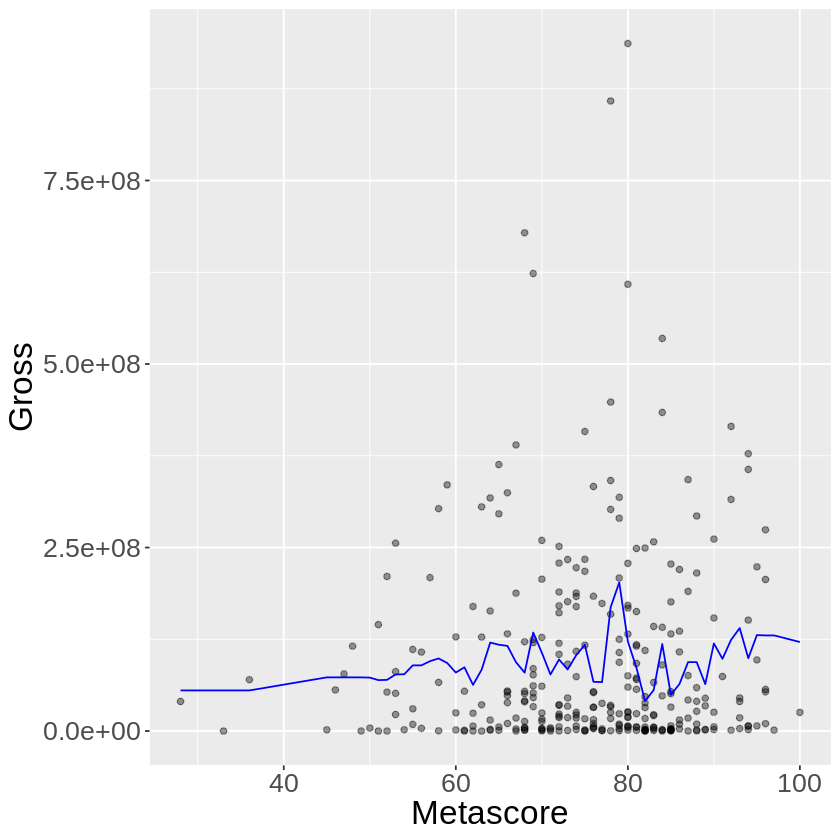

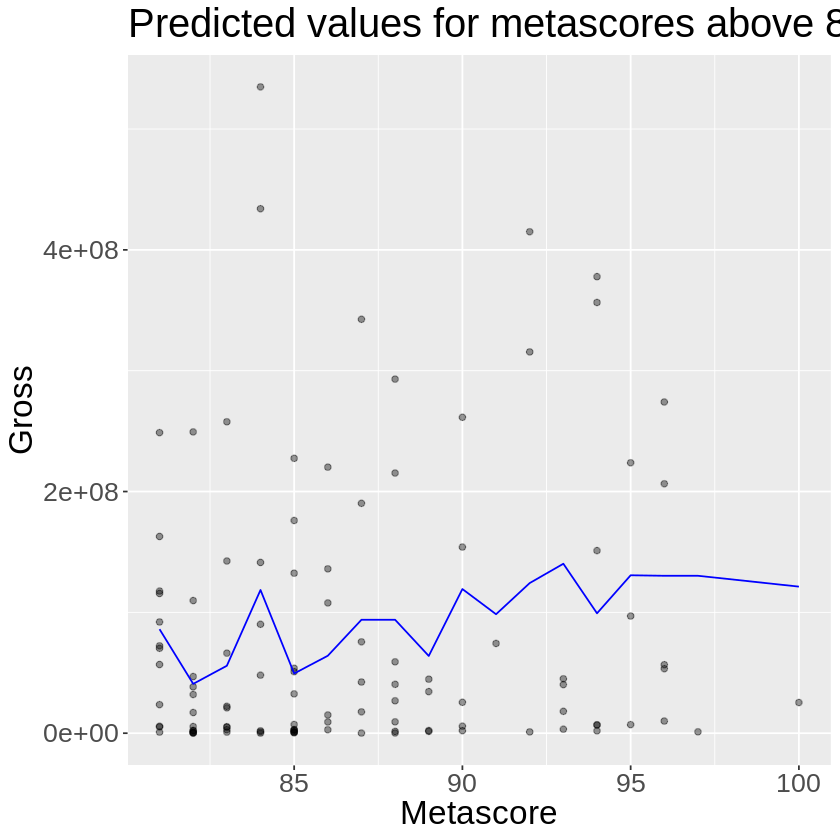

In [61]:
set.seed(2019) # DO NOT CHANGE

options(repr.plot.width = 7, repr.plot.height = 7)


movie_preds <- movie_best_fit %>%
                predict(movie_training) %>%
                bind_cols(movie_training)


movie_plot <- ggplot(movie_preds, aes(x = Meta_score, y = Gross)) +
            geom_point(alpha = 0.4) +
            xlab("Metascore") +
            ylab("Gross") + 
            geom_line(data = movie_preds, aes(x = Meta_score, y = .pred), color = "blue") +
            theme(text = element_text(size = 20))
movie_plot
## filtered for metascore > 81
movie_filtered <- filter(movie_filtered, Meta_score >= 81)

movie_plot2 <- ggplot(movie_filtered, aes(x = Meta_score, y = Gross)) +
            geom_point(alpha = 0.4) +
            xlab("Metascore") +
            ylab("Gross") + 
            ggtitle("Metascores above 81") +
            geom_line(data = movie_filtered, aes(x = Meta_score, y = .pred), color = "blue") +
            theme(text = element_text(size = 20))
movie_plot2
